<a href="https://colab.research.google.com/github/WHU-Peter/COMP6200-Project/blob/main/project_demo_learnable.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [28]:
import torch
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch import nn
from torch import optim
from torch.optim import *
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
import math
import matplotlib.pyplot as plt
import copy

# fix random seed for reproducibility
seed = 7
torch.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
import numpy as np
np.random.seed(seed)

device = "cuda:0" if torch.cuda.is_available() else "cpu"

In [2]:
# flatten 28*28 images to a 784 vector for each image
transform = transforms.Compose([
    transforms.ToTensor(),  # convert to tensor
    transforms.Lambda(lambda x: x.view(-1))  # flatten into vector
])

trainset = MNIST(".", train=True, download=True, transform=transform)
testset = MNIST(".", train=False, download=True, transform=transform)

# create data loaders
trainloader = DataLoader(trainset, batch_size=128, shuffle=True)
testloader = DataLoader(testset, batch_size=128, shuffle=True)

class_counts = torch.zeros(10, dtype=torch.int32)

for (images, labels) in trainloader:
  for label in labels:
    class_counts[label] += 1

assert class_counts.sum()==60000

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [3]:
class SoftMaxWithTemperature(nn.Module):
    def __init__(self, init_temperature):
        super(SoftMaxWithTemperature, self).__init__()
        self.temperature = nn.Parameter(torch.tensor(init_temperature))
    def forward(self, x):
        # print(self.temperature)
        return F.softmax(x / self.temperature, dim=-1)

In [4]:
# define LUTModel
class LUTModelWithLearnableTemperature(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes, init_temperature):
        super(LUTModelWithLearnableTemperature, self).__init__()
        self.softmax_temperature = SoftMaxWithTemperature(init_temperature);
        self.emb = nn.Embedding(input_size, hidden_size) 
        self.fc2 = nn.Linear(hidden_size, num_classes)  
    
    def forward(self, x):
        out = self.softmax_temperature(x)
        out = out @ self.emb.weight
        # out = self.emb(out.long())
        # out = self.emb(out)
        out = F.relu(out)
        out = self.fc2(out)
        if not self.training:
            out = F.softmax(out, dim=1)
        return out

In [ ]:
# build the model
TemperatureParameters = [1e-3, 1e-2, 1e-1, 5e-1, 10e-1]
TemperatureList = [[]] * 5
LossList = [[]] * 5
idx = 0
for i in TemperatureParameters:
  learnable_lut_model = LUTModelWithLearnableTemperature(784, 784, 10, i).to(device)
  # define the loss function and the optimiser
  loss_function = nn.CrossEntropyLoss()
  optimiser = optim.Adam(learnable_lut_model.parameters(), lr=1e-2)
  Temperature = []
  Temperature.append(optimiser.param_groups[0]['params'][0].detach().cpu().numpy())
  Loss_Learnable_Model = []
  # the epoch loop
  for epoch in range(50):
    running_loss = 0.0
    for data in trainloader:
        # get the inputs
        inputs, labels = data

        # zero the parameter gradients
        optimiser.zero_grad()

        # forward + loss + backward + optimise (update weights)
        outputs = learnable_lut_model(inputs.to(device))
        loss = loss_function(outputs, labels.to(device))
        loss.backward()
        optimiser.step()
        # print(optimiser.param_groups[0]['params'][2])
        # print(np.all(optimiser.param_groups[0]['params'][0].grad.numpy() == 0))
        # keep track of the loss this epoch
        running_loss += loss.item()
        # break
    print(optimiser.param_groups[0]['params'][0])
    print("Epoch %d, loss %4.2f" % (epoch, running_loss))
    Loss_Learnable_Model.append(running_loss)
    Temperature.append(optimiser.param_groups[0]['params'][0].detach().cpu().numpy())

  TemperatureList[idx] = Temperature
  LossList[idx] = Loss_Learnable_Model
  idx = idx + 1
print('**** Finished Training ****')

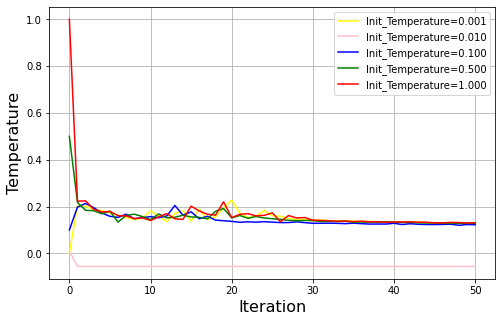

In [33]:
Color = ['yellow', 'pink', 'blue', 'green', 'red']

fig, ax = plt.subplots(nrows=1, ncols=1,figsize=(8,5))
for i in range(len(TemperatureList)):
  ax.plot(TemperatureList[i], Color=Color[i], label='Init_Temperature=%.3f'%TemperatureParameters[i])
ax.set_xlabel("Iteration", fontsize=16)
ax.set_ylabel("Temperature", fontsize=16)
# ax.set_title("Linear Model", fontsize=16)
ax.grid()
ax.legend()
# ax.yaxis.set_major_locator(y_major_locator)
plt.show()

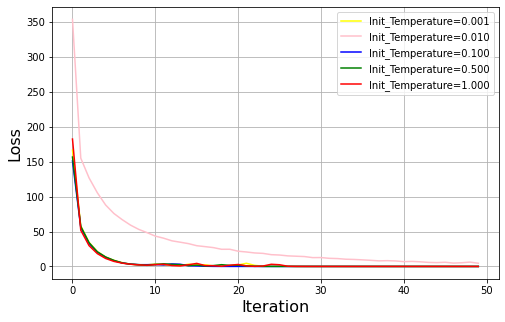

In [35]:
fig, ax = plt.subplots(nrows=1, ncols=1,figsize=(8,5))
for i in range(len(TemperatureParameters)):
  ax.plot(LossList[i], Color=Color[i], label='Init_Temperature=%.3f'%TemperatureParameters[i])
ax.set_xlabel("Iteration", fontsize=16)
ax.set_ylabel("Loss", fontsize=16)
# ax.set_title("Linear Model", fontsize=16)
ax.grid()
ax.legend()
# ax.yaxis.set_major_locator(y_major_locator)
plt.show()